In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pywt
from scipy.fftpack import fft
import librosa
from tqdm.notebook import tqdm
import librosa.display
import glob
import joblib

In [26]:
scale_file = "all_actors/03-01-01-01-01-01-01.wav"
scale, sr = librosa.load(scale_file)

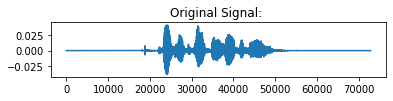

In [27]:
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(scale)
plt.show()

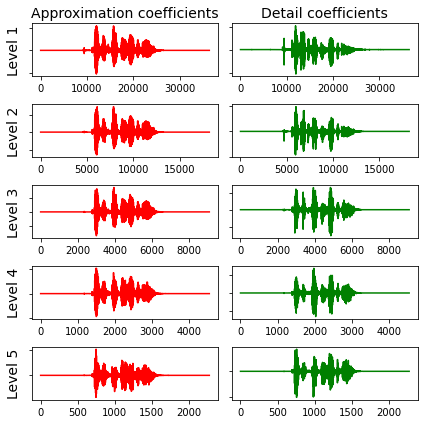

In [32]:
data = scale
waveletname = 'db1' # Daubechies
approximation_coeffs = []
detail_coeffs = []
    
    
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    
    approximation_coeffs.append(data)
    detail_coeffs.append(coeff_d)
    
    
plt.tight_layout()
plt.show()

# extraction methods

In [3]:
def get_bank_high_low_pass(data, waveletname='db1', lvls=5):
    approximation_coeffs, detail_coeffs = [],[]
    for i in range(lvls):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        approximation_coeffs.append(data)
        detail_coeffs.append(coeff_d)
        
    return approximation_coeffs, detail_coeffs

In [4]:
def get_mfccs_from_bank(coeffs, sr, mean=True):
    spectograms = []
    for signal in coeffs:
        mfccs = librosa.feature.mfcc(y=signal, sr=22050, n_mfcc=40)
        if mean:
            spectograms.append(np.mean(mfccs.T, axis=0))     
        else:
            spectograms.append(mfcc)
            
    return spectograms

In [5]:
def extract(audio_file):
    name=os.path.basename(audio_file)
    name=os.path.splitext(name)[0]
    label = int(name[7:8]) - 1
    
    return label, audio_file

def get_high_low_feats(dir_name):
    dir_name = glob.glob(dir_name + "/*.wav")
    approximation_raw, detail_raw, approximation_spec, detail_spec, y = [], [], [], [], []
    
    #progression bar 
    file_count = len(dir_name)
    bar = tqdm(desc="proccessing files", total=file_count)
    tot = 0

    for file in dir_name:
        #get signal
        bar.update(1)
        tot += 1
        label, audio_file = extract(file)
        signal, sr = librosa.load(audio_file)
        
        #get high low pass
        raw = get_bank_high_low_pass(signal, lvls=5)
        approximation_raw.append(raw[0])
        detail_raw.append(raw[1])
        
        #get spectograms
        approximation_spec.append(get_mfccs_from_bank(raw[0], sr, mean=True))
        detail_spec.append(get_mfccs_from_bank(raw[1], sr, mean=True))
        
        y.append(label)
        
        
    
    return approximation_raw, detail_raw, approximation_spec, detail_spec

In [6]:
dir_path = "toronto_ds/conc_data"

In [7]:
approximation_raw, detail_raw, approximation_spec, detail_spec = get_high_low_feats(dir_path)